# import packages
Let's start by importing the following packages!
* requests
* BeautifulSoup
* seaborn
* matplotlib
* pandas
* re

In [1]:
# import package
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# crawler THSR information
Let's start to crawl the imformation of each station of THSR!
* Target web: [THSR Homepage](https://www.thsrc.com.tw)  
* Choose each station:
    1. Homepage -> Travel Information -> Stations
    2. choose different stations by changing url
* Task:
    1. crawler the name, address, operation hours and ticketing hours of each station
    2. organize into a DataFrame

In [2]:
# setting each station name and their url
# 先拿其中一站的網頁獲取我們所要的資訊
url = 'https://www.thsrc.com.tw/ArticleContent/2f940836-cedc-41ef-8e28-c2336ac8fe68'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

#新建一個dict用來存放站名跟url
href_dict = {'station':[],'href':[]}

#找出站名
all_stations = soup.find('div',class_='nav nav-tabs si-tab swiper-wrapper')
for i in all_stations.text.split():
    href_dict['station'].append(i)

#找出各站的url    
station_url = all_stations.find_all('a')
for i in station_url:
     href_dict['href'].append(i.get('href'))

In [3]:
# crawler the address of each station
# 新建一個dict用來存放站名跟地址
address_dict = {'station':[],'address':[]}
all_stations = soup.find('div',class_='nav nav-tabs si-tab swiper-wrapper')
for i in all_stations.text.split():
    address_dict['station'].append(i)

# 用href_dict找出各站的url
for i in href_dict['href']:
    url = 'https://www.thsrc.com.tw'+i
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    #找出基本資訊
    basic_data = soup.find('table',class_='table')
    #利用基本資訊找到地址
    address= basic_data.find('a')
    address_dict['address'].append(address.text)


In [4]:
# crawler the operation hours and ticketing hours of each station

# 新建一個dict用來存放站名跟營運&售票時間
time_dict = {'station':[],'operation_hours':[],'ticketing_hours':[]}
all_stations = soup.find('div',class_='nav nav-tabs si-tab swiper-wrapper')
for i in all_stations.text.split():
    time_dict['station'].append(i)


for i in href_dict['href']:
    url = 'https://www.thsrc.com.tw'+i
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    #找出基本資訊
    basic_data = soup.find('table',class_='table')
    #利用基本資訊找到時間
    time =basic_data.find_all('td',class_='gray')
    
    #建立一個list用來存資料清洗後只剩後面的時間
    a = []
    for j in time:
        a.extend((re.findall('[\d\:\d\~ \w]+',j.text)[1:]))
    #operation_hours
    time_dict['operation_hours'].extend(a[:1])
    #ticketing_hours
    time_dict['ticketing_hours'].extend(a[1:])

In [5]:
# create a DataFrame
address = pd.DataFrame(address_dict)
time = pd.DataFrame(time_dict)

# 合併資料
df = address.merge(time)
df

,station,address,operation_hours,ticketing_hours
0,南港,台北市南港區南港路一段313號,05:50 ~ 24:00,05:50 ~ 末班車發車時間
1,台北,台北市北平西路3號,06:00 ~ 24:00,06:00 ~ 末班車發車時間
2,板橋,新北市板橋區縣民大道二段7號,06:00 ~ 24:00,06:00 ~ 末班車發車時間
3,桃園,桃園市中壢區高鐵北路一段6號,06:20 ~ 23:45,06:20 ~ 末班車發車時間
4,新竹,新竹縣竹北市高鐵七路6號,06:15 ~ 23:45,06:15 ~ 末班車發車時間
5,苗栗,苗栗縣後龍鎮高鐵三路268號,06:05 ~ 23:45,06:05 ~ 末班車發車時間
6,台中,台中市烏日區站區二路8號,05:40 ~ 24:00,05:40 ~ 末班車發車時間
7,彰化,彰化縣田中鎮站區路二段99號,06:20 ~ 24:00,06:20~末班車發車時間
8,雲林,雲林縣虎尾鎮站前東路301號,06:15 ~ 23:45,06:15~末班車發車時間
9,嘉義,嘉義縣太保市高鐵西路168號,06:00 ~ 23:45,06:00~末班車發車時間


# Crawler GDP and CPI
Let's start to crawl GDP and CPI!
* Target web: 
    1. [Wiki GDP](https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal))  
    2. [Wiki CPI](https://en.wikipedia.org/wiki/Corruption_Perceptions_Index)
* Task:
    1. crawler GDP table (top 50: United States ~ New Zealand)
    2. organize into a DataFrame (columns: Country, Region, IMF_Estimate, IMF_Year, United_Nations_Estimate, United_Nations_Year, World_Bank_Estimate, World_Bank_Year)
    3. crawler CPI table which contains country and 2020 CPI (top 100: Denmark ~ Suriname)
    4. organize into a DataFrame (columns: Country, CPI_2020)
    5. merge GDP(DataFrame) and CPI(DataFrame), based on Country of GDP
    6. plot and text the names of GDP top 10 countrys

In [6]:
# crawler GDP

url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

GDP_dict = {'Country':[],'Region':[],'IMF_Estimate':[],'IMF_Year':[],'United_Nations_Estimate':[],
            'United_Nations_Year':[],'World_Bank_Estimate':[],'World_Bank_Year':[]}

summary = soup.find('table',class_='wikitable sortable static-row-numbers plainrowheaders srn-white-background')
table = summary.find_all(['td'])
GDP = []

for i in table:
    #去除掉數字前的[]
    GDP.append(re.sub('\[.*?]','',i.text.strip()))
for i in range(0,400,8):
    GDP_dict['Country'].append(GDP[i])
    GDP_dict['Region'].append(GDP[i+1])
    #將數字的逗號拿掉
    GDP_dict['IMF_Estimate'].append(re.sub('\,','',GDP[i+2]))
    GDP_dict['IMF_Year'].append(GDP[i+3])
    GDP_dict['United_Nations_Estimate'].append(re.sub('\,','',GDP[i+4]))
    GDP_dict['United_Nations_Year'].append(GDP[i+5])
    GDP_dict['World_Bank_Estimate'].append(re.sub('\,','',GDP[i+6]))
    GDP_dict['World_Bank_Year'].append(GDP[i+7])


In [7]:
# create GDP DataFrame
GDP_df = pd.DataFrame(GDP_dict)
GDP_df

,Country,Region,IMF_Estimate,IMF_Year,United_Nations_Estimate,United_Nations_Year,World_Bank_Estimate,World_Bank_Year
0,United States,Americas,22675271,2021,21433226,2019,20936600,2020
1,China,Asia,16642318,2021,14342933,2019,14722731,2020
2,Japan,Asia,5378136,2021,5082465,2019,4975415,2020
3,Germany,Europe,4319286,2021,3861123,2019,3806060,2020
4,United Kingdom,Europe,3124650,2021,2826441,2019,2707744,2020
5,India,Asia,3049704,2021,2891582,2019,2622984,2020
6,France,Europe,2938271,2021,2715518,2019,2603004,2020
7,Italy,Europe,2106287,2021,2003576,2019,1886445,2020
8,Canada,Americas,1883487,2021,1741496,2019,1643408,2020
9,South Korea,Asia,1806707,2021,1646539,2019,1630525,2020


In [8]:
# crawler CPI
url = 'https://en.wikipedia.org/wiki/Corruption_Perceptions_Index'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

CPI_dict = {'Country':[],'CPI_2020':[]}
summary = soup.find('div',class_="mw-parser-output")
table = summary.find('table',class_='wikitable sortable')
columns = table.find_all(['td'])

CPI = []

for i in columns:
    CPI.append(i.text.strip())

for i in range(0,1900,19):
    CPI_dict['Country'].append(CPI[i+1])
    CPI_dict['CPI_2020'].append(CPI[i+2])


In [9]:
# CPI DataFrame
CPI_df = pd.DataFrame(CPI_dict)
CPI_df

,Country,CPI_2020
0,Denmark,88
1,New Zealand,88
2,Finland,85
3,Singapore,85
4,Sweden,85
...,...,...
95,Kazakhstan,38
96,Peru,38
97,Serbia,38
98,Sri Lanka,38


In [10]:
# merge GDP and CPI DataFrame
df =GDP_df.merge(CPI_df)
df

,Country,Region,IMF_Estimate,IMF_Year,United_Nations_Estimate,United_Nations_Year,World_Bank_Estimate,World_Bank_Year,CPI_2020
0,United States,Americas,22675271,2021,21433226,2019,20936600,2020,67
1,China,Asia,16642318,2021,14342933,2019,14722731,2020,42
2,Japan,Asia,5378136,2021,5082465,2019,4975415,2020,74
3,Germany,Europe,4319286,2021,3861123,2019,3806060,2020,80
4,United Kingdom,Europe,3124650,2021,2826441,2019,2707744,2020,77
5,India,Asia,3049704,2021,2891582,2019,2622984,2020,40
6,France,Europe,2938271,2021,2715518,2019,2603004,2020,69
7,Italy,Europe,2106287,2021,2003576,2019,1886445,2020,53
8,Canada,Americas,1883487,2021,1741496,2019,1643408,2020,77
9,South Korea,Asia,1806707,2021,1646539,2019,1630525,2020,61


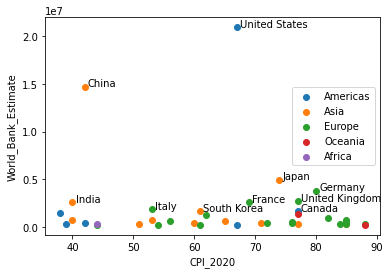

In [11]:
# plot
#將string轉換數值
df.CPI_2020 = pd.to_numeric(df.CPI_2020)
df.World_Bank_Estimate = pd.to_numeric(df.World_Bank_Estimate)
for i in df.Region.unique():
    x = df.CPI_2020[df.Region == i]
    y = df.World_Bank_Estimate[df.Region == i]
    plt.scatter(x,y)

#加入前10名的國家名字
text = list(df.Country[0:10])
for i in range(len(text)):
    plt.text(df.CPI_2020[i]+0.5, df.World_Bank_Estimate[i]+0.5,text[i])
    
#重新命名X&Y軸
plt.xlabel('CPI_2020')
plt.ylabel('World_Bank_Estimate')
plt.legend(labels=['Americas','Asia','Europe','Oceania','Africa'],loc='center right')